In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential


In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [9]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [10]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


In [15]:
#there are 32 images and the dimensions of each image is 256*256 and 3 stands for RGB

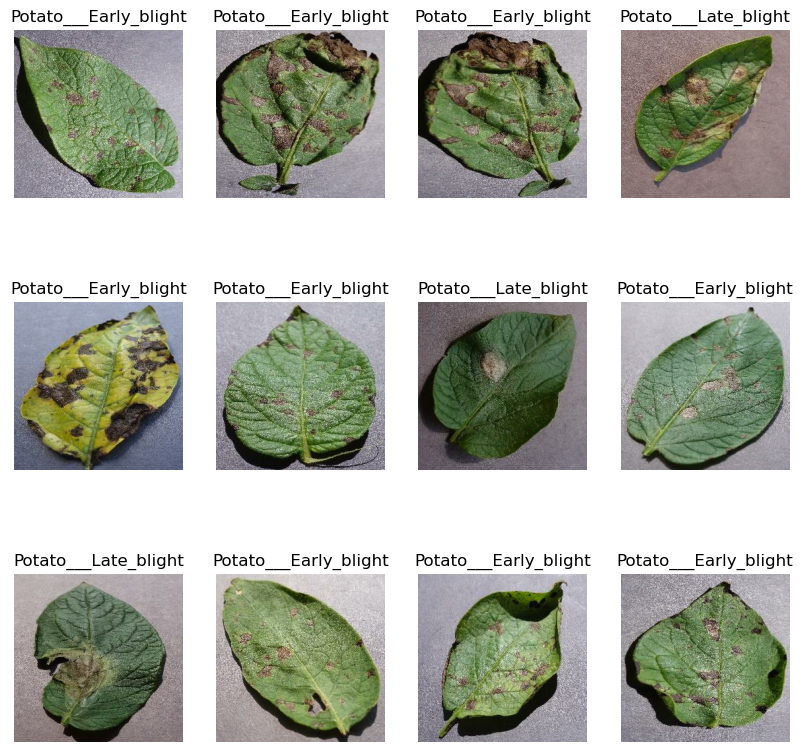

In [17]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [18]:
len(dataset)

68

In [19]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [23]:
train_ds = dataset.take(54)
len(train_ds)

54

In [25]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [27]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [29]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [31]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [33]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [35]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [37]:
len(train_ds)


54

In [39]:
len(val_ds)


6

In [41]:
len(test_ds)


8

Cache, Shuffle, and Prefetch the Dataset

In [44]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Change the sizes of the images (ken mehomch 256*256)

In [47]:
resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255),
])

In [49]:
#el data augmentation hiye when u choose an image and make other more images from it (you change the contrast
#or rotate or flip it ) in order to better train our model

In [51]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [53]:
#in this part we are gonna use CNNs (convolution neural networks ) that is used in image classification

In [55]:
# In Convolutional Neural Networks (CNNs), the sequence of convolution → pooling → convolution → pooling → flatten represents the standard progression of processing data to extract features, reduce dimensions, and prepare it for classification or regression tasks. Let’s break this down step by step:

# 1. Convolution Layer
# Purpose: Extracts features from the input image, such as edges, textures, or patterns.
# How it Works:
# A kernel/filter (small matrix) slides over the input image.
# Each position performs element-wise multiplication and sums the result (dot product).
# This produces a feature map that highlights certain features (like edges or patterns) based on the filter.
# Why it's Important:
# Captures spatial hierarchies (local relationships) in the data.
# Multiple filters can extract different types of features.
# 2. Pooling Layer
# Purpose: Reduces the spatial dimensions of the feature map to make computations more efficient and retain important information.
# How it Works:
# Applies an operation like Max Pooling (takes the maximum value) or Average Pooling (takes the average value) over small, non-overlapping regions of the feature map.
# Reduces the size of the feature map while preserving the most significant features.
# Why it's Important:
# Reduces computational load by lowering the number of parameters.
# Provides translational invariance (helps the model recognize patterns regardless of their position in the image).
# 3. Repeat Convolution and Pooling
# Purpose: Build a hierarchy of features, starting from low-level (e.g., edges) to high-level (e.g., object parts).
# How it Works:
# Each successive convolution layer processes the feature maps from the previous layer to extract more abstract and complex features.
# Pooling continues to downsample the data, focusing on the most relevant features.
# Why it's Important:
# Allows the network to learn both fine-grained and coarse features.
# Helps in abstracting the data for better understanding by the fully connected layers.
# 4. Flatten Layer
# Purpose: Transforms the final feature maps into a 1D vector to pass it to the Dense (fully connected) layers.
# How it Works:
# If the final feature map has dimensions 
# ℎ×𝑤×𝑐
# h×w×c (height, width, channels), flattening converts it into a 1D array of size 
# ℎ×𝑤×𝑐
# h×w×c.
# This vector contains all the extracted features in a linear form.
# Why it's Important:
# Fully connected layers (Dense layers) expect a 1D input.
# The flattened vector acts as a bridge between the convolutional part (feature extraction) and the Dense part (decision-making).
# 5. Fully Connected Layers
# After flattening, the vector is passed through Dense layers.
# These layers learn to classify or make predictions based on the extracted features.
# Illustrative Example
# Imagine you’re building a CNN to classify images of cats and dogs:

# First Convolution: Detects low-level features like edges and lines.
# First Pooling: Downsamples the feature map to retain important edges.
# Second Convolution: Detects combinations of edges, such as shapes (e.g., ears or tails).
# Second Pooling: Further reduces the spatial dimensions, focusing on key features.
# Flatten: Converts the abstracted features (e.g., "cat ears") into a 1D vector.
# Dense Layers: Classify the image based on the learned features (e.g., "cat" or "dog").
# Advantages of This Process
# Feature Hierarchies:
# Initial layers capture basic patterns, while deeper layers capture more complex structures.
# Dimensionality Reduction:
# Pooling and flattening reduce data size, making training more efficient.
# Parameter Efficiency:
# Pooling and convolution allow the model to focus on key features rather than redundant details.

In [81]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [59]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# tawa bech na3mlou el compile ta3 el model

In [63]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [121]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 128s 2s/step - accuracy: 0.4623 - loss: 0.9439 - val_accuracy: 0.6771 - val_loss: 0.7777
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.6605 - loss: 0.7058 - val_accuracy: 0.8125 - val_loss: 0.4453
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8246 - loss: 0.4252 - val_accuracy: 0.8073 - val_loss: 0.4015
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8769 - loss: 0.3050 - val_accuracy: 0.8802 - val_loss: 0.3571
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.8817 - loss: 0.2980 - val_accuracy: 0.9583 - val_loss: 0.1392
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9418 - loss: 0.1611 - val_accuracy: 0.9427 - val_loss: 0.1721
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.9446 - loss: 0.1488 - val_accuracy: 0.9635 - val_loss: 0.1410
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.9570 - loss: 0.1180 - val_accuracy: 0.9323 - val_loss

In [65]:
scores = model.evaluate(test_ds)


8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 739ms/step - accuracy: 0.0674 - loss: 1.1279


In [67]:
scores


[1.1215753555297852, 0.07421875]

In [129]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 54}

In [131]:
history.history.keys()


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [133]:
type(history.history['loss'])


list

In [135]:
len(history.history['loss'])


50

In [137]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.8894577026367188,
 0.6278114914894104,
 0.38749003410339355,
 0.3106703460216522,
 0.24313145875930786]

In [139]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

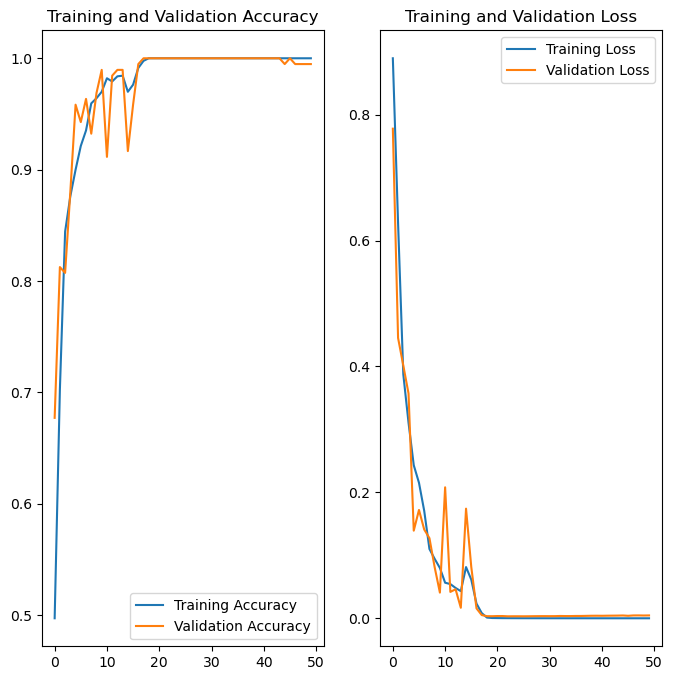

In [141]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 662ms/step
predicted label: Potato___Early_blight


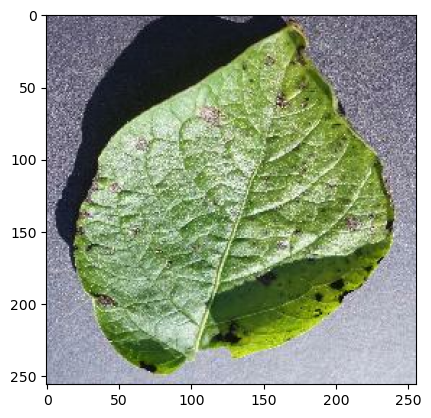

In [145]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [147]:
###na3mlou function to predict 

In [149]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


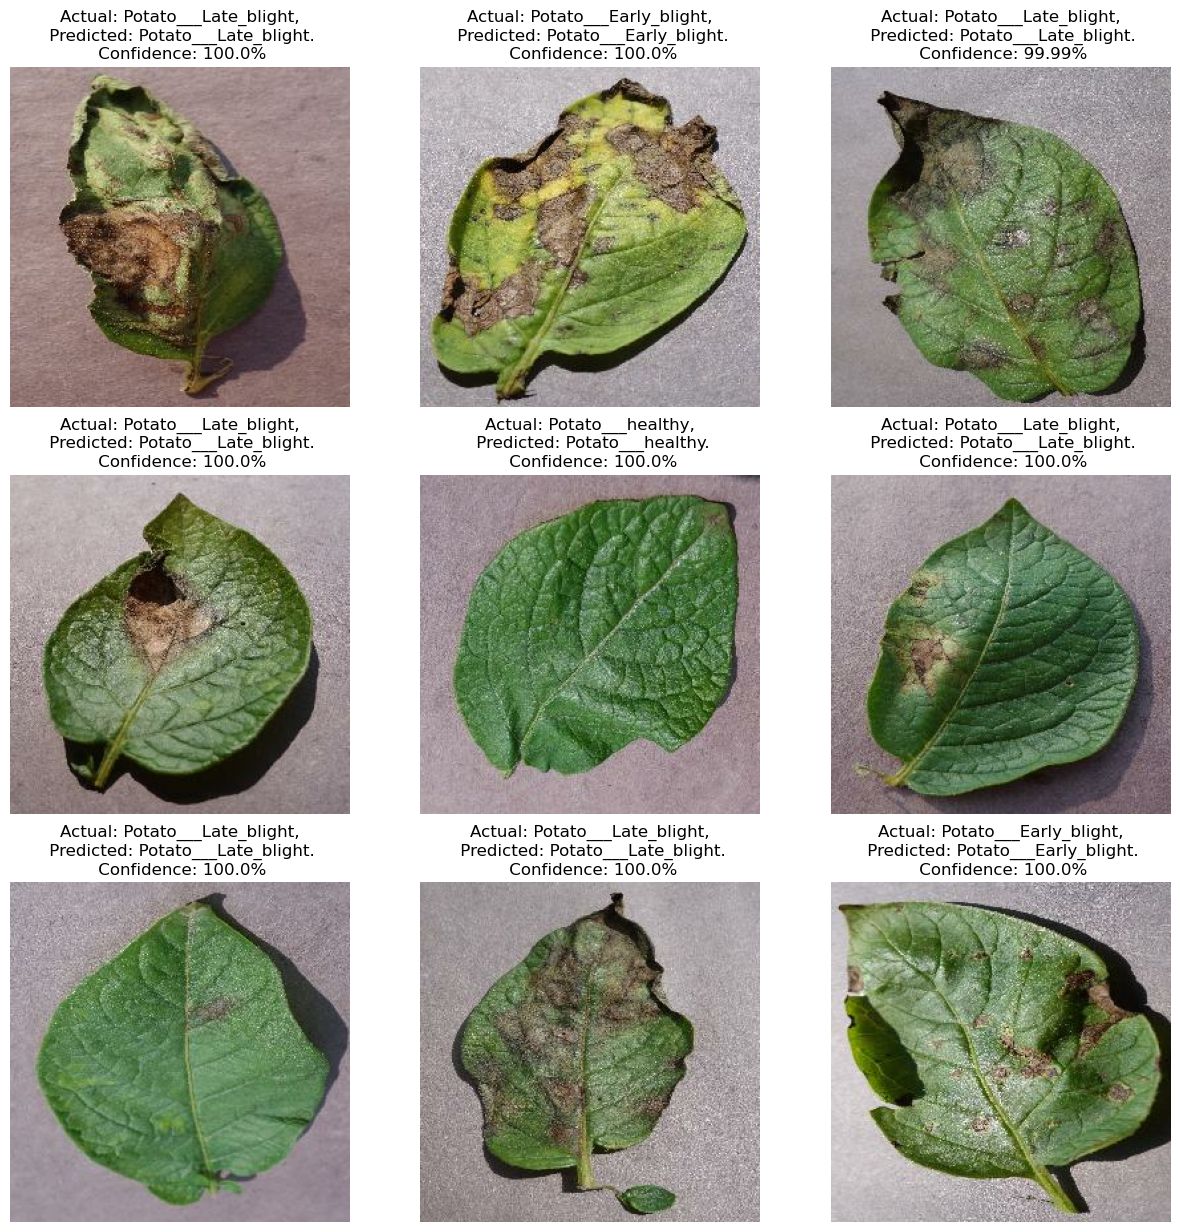

In [151]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [79]:
import os

model_version = max([int(i) for i in os.listdir("../models") if i.isdigit()] + [0]) + 1
model.save(f"../models/{model_version}.keras")
